In [24]:
import pandas as pd

from core.fs import FsLoader
from core.repository.maria.conn import maria_home
from utils.timeutil import YearMonth
from utils.timeutil import YearQtr

begin = YearMonth(2014, 4)
end = YearMonth(2024, 1)

# 월 차트 로드
print("Fetching month chart...")
month_chart = pd.read_sql(
    f"""
    select month_chart.* from month_chart
    where year(date) >= {begin.year}
    """,
    maria_home()
)

# 재무제표 로드
print("Loading financial data...")
fs_loader = FsLoader()

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()

print("Making layer1...")
for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df1 = df1[df1["date"] == df1["date"].max()]  # date = date.max 아니면, 상장폐지 되는 종목. 매수일이 월말이기 때문에 매수 불가
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
    df2["date"] = df2["date"].max()  # date = date.max 아니면, 상장폐지 되는 종목. 정리매매 거치기 때문에 별도 처리 필요 없음.
    df1 = df1[df1["open"] > 0]  # 시가=0 은 거래정지, 따라서 매수불가
    df1 = df1[df1["val_last"] > 1_000_0000]  # 거래량 일정 수준 이상(거래량 적을 시 매수 실패할거라고 가정)
    df2["close"] = df2["close"].astype(float)
    df2.loc[(df2["open"] == 0), "close"] /= 2  # 거래정지 시 투자금이 1/2 된다고 가정

    df = pd.DataFrame({
        "매수년월": ym1,
        "매도년월": ym2,
        "종목명": df1["name"],
        "매수일": df1["date"],
        "매수가": df1["close"],
        "P": df1["cap"],
        "vol": df1["vol"],
        "val": df1["val"],
        "shares": df1["shares"],
        "avg": df1["avg"],
        "전월수익률": df1["close"] / df1["open"] - 1,
        "매도가": df2["close"],
        "매도일": df2["date"]
    }).reindex(df1.index)

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거
    df.loc[df["매도가"].isna(), "매도가"] = 0
    df["수익률"] = df["매도가"] / df["매수가"] - 1

    settled_qtr = YearQtr.settled_of(ym1.last_date)
    fn = fs_loader.load(settled_qtr.year, settled_qtr.qtr)
    layer1 = pd.concat([layer1, df.join(fn)])

layer1.reset_index(inplace=True)
layer1.to_csv(".cache/layer1.csv", index=False)

Fetching month chart...
Loading financial data...
Making layer1...


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from utils.timeutil import YearMonth

layer1 = pd.read_csv(".cache/layer1.csv", dtype={"code": str})
layer1["매수년월"] = layer1["매수년월"].apply(lambda x: YearMonth.from_string(x))
layer1["매도년월"] = layer1["매도년월"].apply(lambda x: YearMonth.from_string(x))

font_path = '../res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

layer1 = layer1[layer1["확정실적"].notna()]
layer1.shape

(209805, 55)

In [26]:
import numpy as np

layer2 = layer1.copy()


def add_factor(name, value):
    factors.append(name)
    layer2[name] = value


factors = ["P", "수익률", "val"]
factors += [col for col in layer1.columns if col.endswith("QoQ")]

add_factor("logP", np.ceil(np.log2(layer2["P"])))

# 가격비율
add_factor("EQ/P", layer2["EQ"] / layer2["P"])

is_cols = ["R", "GP", "O", "EBT", "E"]
for col in is_cols:
    add_factor(f"{col}/P", layer2[f"{col}/Y"] / layer2["P"])
    add_factor(f"{col}/A", layer2[f"{col}/Y"] / layer2["A"])  # 자산비율
    add_factor(f"{col}/EQ", layer2[f"{col}/Y"] / layer2["EQ"])  # 자본비율
    if col != "R":
        add_factor(f"{col}/R", layer2[f"{col}/Y"] / layer2["R/Y"])  # 이익율

add_factor("유동부채비율", layer1["유동부채"] / layer1["유동자산"])

# RECIPE ==========================================================

recipes = {
    "벨류": {
        "GP/P": 0.120550,
        "EQ/P": 0.105678,
    },
    "퀄리티": {
        "GP/A": 0.032862,
        "GP/EQ": 0.028487,
        "R/A": 0.012971,
        "GP/R": 0.012141,
        "O/A": 0.009835,
        "E/R": 0.005616,
        "EBT/A": 0.005415,
        "O/EQ": 0.005188,
        "O/R": 0.004577,
        "R/EQ": 0.004484,
        "EBT/R": 0.003881,
        "E/A": 0.003815,
        "EBT/EQ": 0.003162,
        "E/EQ": 0.002940
    },
    "성장": {
        "O_QoQ": 0.027,
        "E_QoQ": 0.024,
        "EBT_QoQ": 0.017,
        "O/A_QoQ": 0.013,
        "E/EQ_QoQ": 0.011,
        "O/EQ_QoQ": 0.01,
        "E/A_QoQ": 0.009,
        "EBT/A_QoQ": 0.008,
        "EBT/EQ_QoQ": 0.006,
        "GP/EQ_QoQ": 0.004,
        "GP/A_QoQ": 0.004,
        "GP_QoQ": 0.003,
        "R_QoQ": 0.001,
        "R/EQ_QoQ": 0.001,
        "R/A_QoQ": 0.001,
    },
    "가격": {
        "P": -1
    },
    "전략": {
        "성장": 1,
        "벨류": 1,
        "가격": 1
    },
}

# for k1 in ["R", "GP", "O", "EBT", "E"]:
#     recipes[k1 + "성장"] = {
#         k1 + k2 + "_QoQ": 1 for k2 in ["", "/A", "/EQ"]
#     }
# 
# for k1 in ["_QoQ", "/A_QoQ", "/EQ_QoQ"]:
#     recipes[k1 + "성장"] = {
#         k2 + k1: 1 for k2 in ["R", "GP", "O", "EBT", "E"]
#     }
# 
# recipes["신성장"] = {
#     "_QoQ성장": 1,
#     "O성장": 1
# }

# =================================================================

pct_scale = 100


def calc_pct_by_month(_col: str):
    grouped_by_month = layer2.groupby("매도년월")[_col]
    return grouped_by_month.apply(lambda x: np.ceil(x.rank(pct=True) * pct_scale)).reset_index(level=0, drop=True)


for factor in factors:
    layer2[f"{factor}_pct"] = calc_pct_by_month(factor)

for title, recipe in recipes.items():
    layer2[title] = layer2.apply(lambda row: sum([row[f"{k}_pct"] * w for k, w in recipe.items()]), axis=1)
    layer2[f"{title}_pct"] = calc_pct_by_month(title)

layer2.shape

(209805, 113)

In [27]:
import matplotlib.pyplot as plt

factor = "전략"

returns = layer2.groupby(factor + "_pct").apply(lambda x: x.groupby("매도년월")["수익률"].mean())
if type(returns) is pd.Series:
    returns = returns.to_frame().reset_index().pivot(index=factor + "_pct", columns="매도년월")
    returns = returns.droplevel(level=0, axis=1)

years = returns.columns.min().duration(returns.columns.max())
cagr_by_rank = returns.apply(lambda x: (x + 1).prod() ** (1 / years) - 1, axis=1)
corr_by_month = returns.apply(lambda x: x.corr(pd.Series(x.index)))

# plt.figure(figsize=(10, 6))
# plt.bar([str(month) for month in corr_by_month.index], corr_by_month.values)
# plt.xticks([str(x) for x in corr_by_month.index[::len(corr_by_month) // 8]])

(returns + 1).cumprod(axis=1)

/var/folders/0y/llrn6whd0yv6x4_v5_d124y80000gn/T/ipykernel_16775/409629351.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  returns = layer2.groupby(factor + "_pct").apply(lambda x: x.groupby("매도년월")["수익률"].mean())


매도년월,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,...,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01
전략_pct,,,,,,,,,,,,,,,,,,,,,
1.0,0.966049,0.992764,0.982499,1.007717,0.954980,0.919054,0.883791,0.858858,0.923264,0.971526,...,0.271829,0.278133,0.262609,0.321710,0.320963,0.286593,0.231541,0.274094,0.274238,0.243681
2.0,0.958443,0.864072,0.799868,0.788905,0.816002,0.764815,0.809203,0.763454,0.745323,0.811412,...,0.530794,0.536419,0.516263,0.523837,0.539205,0.469300,0.410151,0.464474,0.451149,0.428273
3.0,0.961825,0.930841,0.943486,0.926317,0.865206,0.838558,0.782385,0.771084,0.788824,0.775229,...,0.323510,0.312958,0.296473,0.295934,0.285217,0.270686,0.238428,0.262271,0.292929,0.265039
4.0,1.019369,0.993153,1.018150,1.053201,1.021877,0.995030,1.044212,1.002746,1.161710,1.195609,...,0.356615,0.357647,0.357924,0.358911,0.356205,0.330842,0.278000,0.315437,0.315788,0.287446
5.0,0.954467,0.946813,0.877976,0.918662,0.919822,0.853079,0.883639,0.848430,0.879560,0.914295,...,0.424572,0.442053,0.444231,0.499765,0.491284,0.458966,0.416234,0.471279,0.500375,0.458533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96.0,1.055537,1.073999,1.175871,1.281525,1.279311,1.416680,1.401373,1.420134,1.521847,1.762799,...,18.620827,19.293015,19.634739,18.416968,18.258183,17.186633,16.705950,17.601136,17.881898,17.780770
97.0,1.060223,1.098622,1.117528,1.127257,1.152421,1.166546,1.164796,1.168946,1.247800,1.386376,...,10.465134,11.617314,12.542209,11.560146,12.326237,11.649234,11.470290,12.332647,12.274889,12.002052
98.0,1.019750,1.038920,1.187549,1.274685,1.516297,1.398706,1.369450,1.420951,1.595145,1.950802,...,11.995417,12.552141,13.216682,12.166133,12.407811,12.204833,11.879720,12.683833,12.872705,12.526185


[2/2] E/A2014-04 2024-01


,strength,slope,spearman,pearson,t10,h10,t10-h10,mean,median
E/A,0.003735,-0.025340,-0.147399,-0.167084,0.063645,0.064930,-0.001285,0.084428,0.081292
E/P,-0.000091,0.004342,-0.020882,0.025651,0.081641,0.109762,-0.028121,0.083999,0.084371


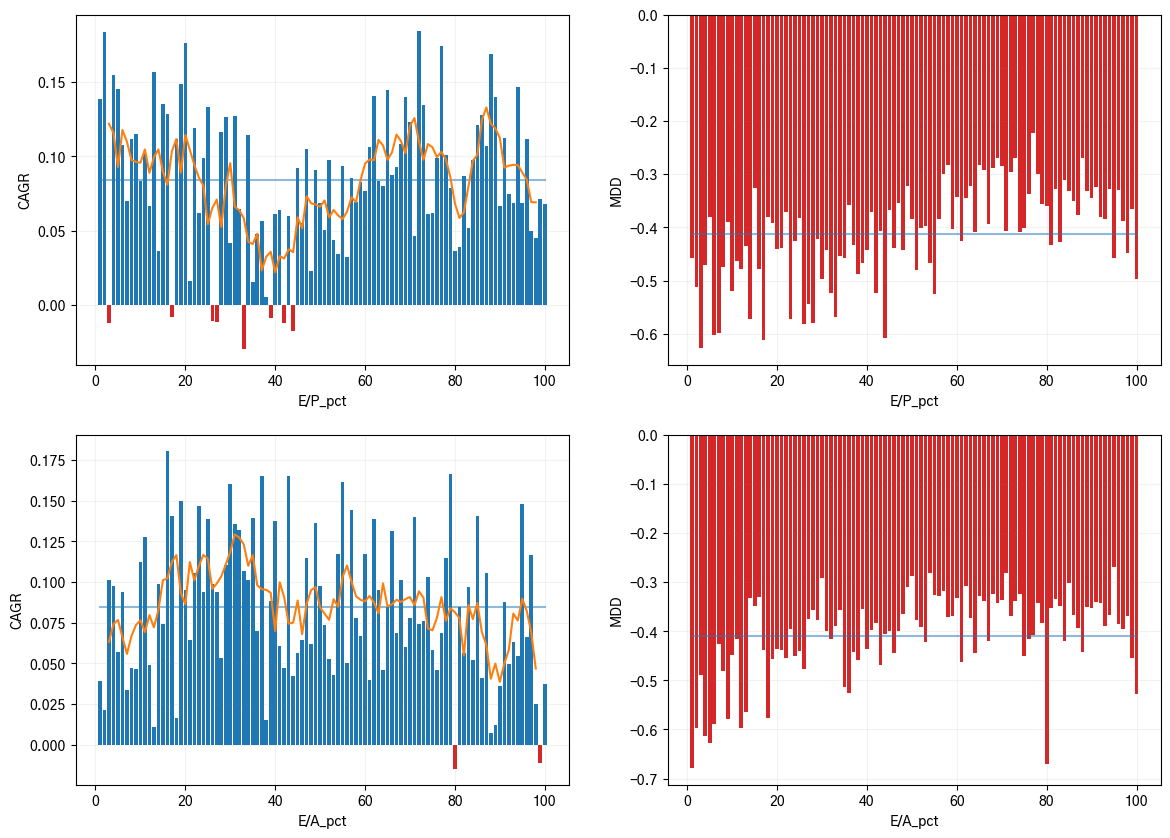

In [28]:
import matplotlib.pyplot as plt
from utils.quantutil import cagr as calc_cagr
from utils.quantutil import mdd as calc_mdd
from utils import pdutil

# target_factors = list(recipes.keys())
target_factors = ["E/P", "E/A"]

fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(14), fig.set_figheight(5 * len(target_factors))
summary = pd.DataFrame()

# 다시.. 그리고..
# mdd
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = layer2[colname].dropna().sort_values().unique()
    cagr, mdd = [], []
    for pct in pcts:
        by_pct = layer2[layer2[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        cagr.append(calc_cagr(1, cumprod.iloc[-1], by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date for s in return_by_ym.index]
        mdd.append(calc_mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    pcts = pd.Series(pcts)
    cagr, mdd = pd.Series(cagr), pd.Series(mdd)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr, color=["tab:blue" if v > 0 else "tab:red" for v in cagr])
    ax1.plot(pd.Series(pcts), [cagr.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd, color=["tab:blue" if v > 0 else "tab:red" for v in mdd])
    ax2.plot(pd.Series(pcts), [mdd.mean() for _ in pd.Series(pcts)], alpha=0.5)

    pct_mean = pcts.mean()
    cagr_mean = cagr.mean()

    slope = sum((pcts - pct_mean) * (cagr * 100 - cagr_mean)) / sum((pcts - pct_mean) ** 2)
    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr}).corr(method="spearman")
    pearson = pd.DataFrame({colname: pcts, "CAGR": cagr}).corr()
    summary = pd.concat([
        summary,
        pd.Series({
            "slope": slope,
            "spearman": spearman[colname]["CAGR"],
            "pearson": pearson[colname]["CAGR"],
            "t10": cagr.tail(10).mean(),
            "h10": cagr.head(10).mean(),
            "t10-h10": cagr.tail(10).mean() - cagr.head(10).mean(),
            "mean": cagr.mean(),
            "median": cagr.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["slope"]

print(layer2["매수년월"].min(), layer2["매도년월"].max())
summary = summary.sort_values(by="strength", ascending=False)
summary = summary[pdutil.sort_columns(summary.columns, forward=["strength"])]
summary.to_csv(".cache/summary.csv")
summary

In [29]:
# 백테스트

from utils.quantutil import cagr, mdd

_key = ["매수년월", "매도년월"]
benchmark = layer2.groupby(_key)["수익률"].mean()

strategy_name = "전략"
print(strategy_name)

result2 = layer2.copy()[layer2[strategy_name].notna()]

result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/R_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/R_pct"] > 10]
result2 = result2[result2["EBT/A_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["O/R_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["EBT/R_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["EBT/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

port_size = 30
port = result2.groupby(_key).apply(lambda x: x.sort_values(strategy_name, ascending=False).head(port_size))
strategy = port.reset_index(drop=True).groupby(_key)["수익률"].mean()
strategy = pd.Series(strategy, index=benchmark.index)

revisions = pd.DataFrame({
    "BM 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": strategy - benchmark,
    "BM 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod(),
})

running_max = revisions["BM 누적수익률"].cummax()
revisions["BM DD"] = (revisions["BM 누적수익률"] - running_max) / running_max

running_max = revisions["전략 누적수익률"].cummax()
revisions["전략 DD"] = (revisions["전략 누적수익률"] - running_max) / running_max

revisions = revisions.dropna()

years = len(revisions) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"].iloc[-1], years), cagr(1, revisions["BM 누적수익률"].iloc[-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions["전략 누적수익률"].index], revisions["전략 누적수익률"].tolist()),
            mdd([i2 for _, i2 in revisions.index], revisions["BM 누적수익률"].tolist())],
    "Mean": [revisions["전략 수익률"].mean(), revisions["BM 수익률"].mean()]
}, index=["전략", "BM"])
print(summary)

revisions.to_csv(".cache/revisions.csv")
revisions

전략
        CAGR                                        MDD      Mean
전략  0.362651  (-0.2435979474227591, (2019-04, 2020-03))  0.028906
BM  0.088617  (-0.3236838585927504, (2018-05, 2020-03))  0.008949


/var/folders/0y/llrn6whd0yv6x4_v5_d124y80000gn/T/ipykernel_16775/2030733674.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port = result2.groupby(_key).apply(lambda x: x.sort_values(strategy_name, ascending=False).head(port_size))


,,BM 수익률,전략 수익률,성능,BM 누적수익률,전략 누적수익률,BM DD,전략 DD
매수년월,매도년월,,,,,,,
2014-04,2014-05,-0.001313,0.026284,0.027597,0.998687,1.026284,0.000000,0.000000
2014-05,2014-06,-0.008577,0.011492,0.020069,0.990121,1.038078,-0.008577,0.000000
2014-06,2014-07,0.019002,0.106266,0.087264,1.008935,1.148390,0.000000,0.000000
2014-07,2014-08,0.039388,0.078441,0.039053,1.048675,1.238471,0.000000,0.000000
2014-08,2014-09,0.011842,0.059665,0.047823,1.061094,1.312365,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2023-08,2023-09,-0.058858,-0.046667,0.012191,2.290813,21.595310,-0.228061,-0.124799
2023-09,2023-10,-0.084423,-0.027838,0.056586,2.097414,20.994148,-0.293231,-0.149163
2023-10,2023-11,0.089897,0.018583,-0.071314,2.285965,21.384284,-0.229695,-0.133352


In [30]:
result3 = port.reset_index(drop=True).groupby(_key).apply(lambda x: x.sort_values("수익률", ascending=False))[[
    "code", "종목명", "수익률", "매수일", "매도일", "매수가", "매도가", "consolidated", f"{strategy_name}_pct"
]]
result3 = result3.reset_index(drop=True)
result3.to_csv(".cache/port.csv")
result3

/var/folders/0y/llrn6whd0yv6x4_v5_d124y80000gn/T/ipykernel_16775/3036726810.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result3 = port.reset_index(drop=True).groupby(_key).apply(lambda x: x.sort_values("수익률", ascending=False))[[


,code,종목명,수익률,매수일,매도일,매수가,매도가,consolidated,전략_pct
0,011390,부산산업,0.328386,2014-04-30,2014-05-30,26950.0,35800.0,1.0,100.0
1,038010,제일테크노스,0.216837,2014-04-30,2014-05-30,19600.0,23850.0,1.0,97.0
2,054940,엑사이엔씨,0.215470,2014-04-30,2014-05-30,905.0,1100.0,1.0,98.0
3,014990,인디에프,0.132442,2014-04-30,2014-05-30,823.0,932.0,1.0,97.0
4,021650,한국큐빅,0.123377,2014-04-30,2014-05-30,2310.0,2595.0,1.0,99.0
...,...,...,...,...,...,...,...,...,...
3505,122690,서진오토모티브,-0.097004,2023-12-28,2024-01-31,3505.0,3165.0,1.0,100.0
3506,308100,까스텔바작,-0.098361,2023-12-28,2024-01-31,4880.0,4400.0,1.0,100.0
3507,065060,지엔코,-0.118613,2023-12-28,2024-01-31,548.0,483.0,1.0,100.0
3508,008600,윌비스,-0.149606,2023-12-28,2024-01-31,635.0,540.0,1.0,99.0


[2024-02-04 17:57:47.946] [INFO] [matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-02-04 17:57:47.949] [INFO] [matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-02-04 17:57:47.974] [INFO] [matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-02-04 17:57:47.976] [INFO] [matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-02-04 17:57:47

total            117.000000
out-perform       72.000000
under-perform     23.000000
승률                 0.692308
누적 성능              8.424114
dtype: float64

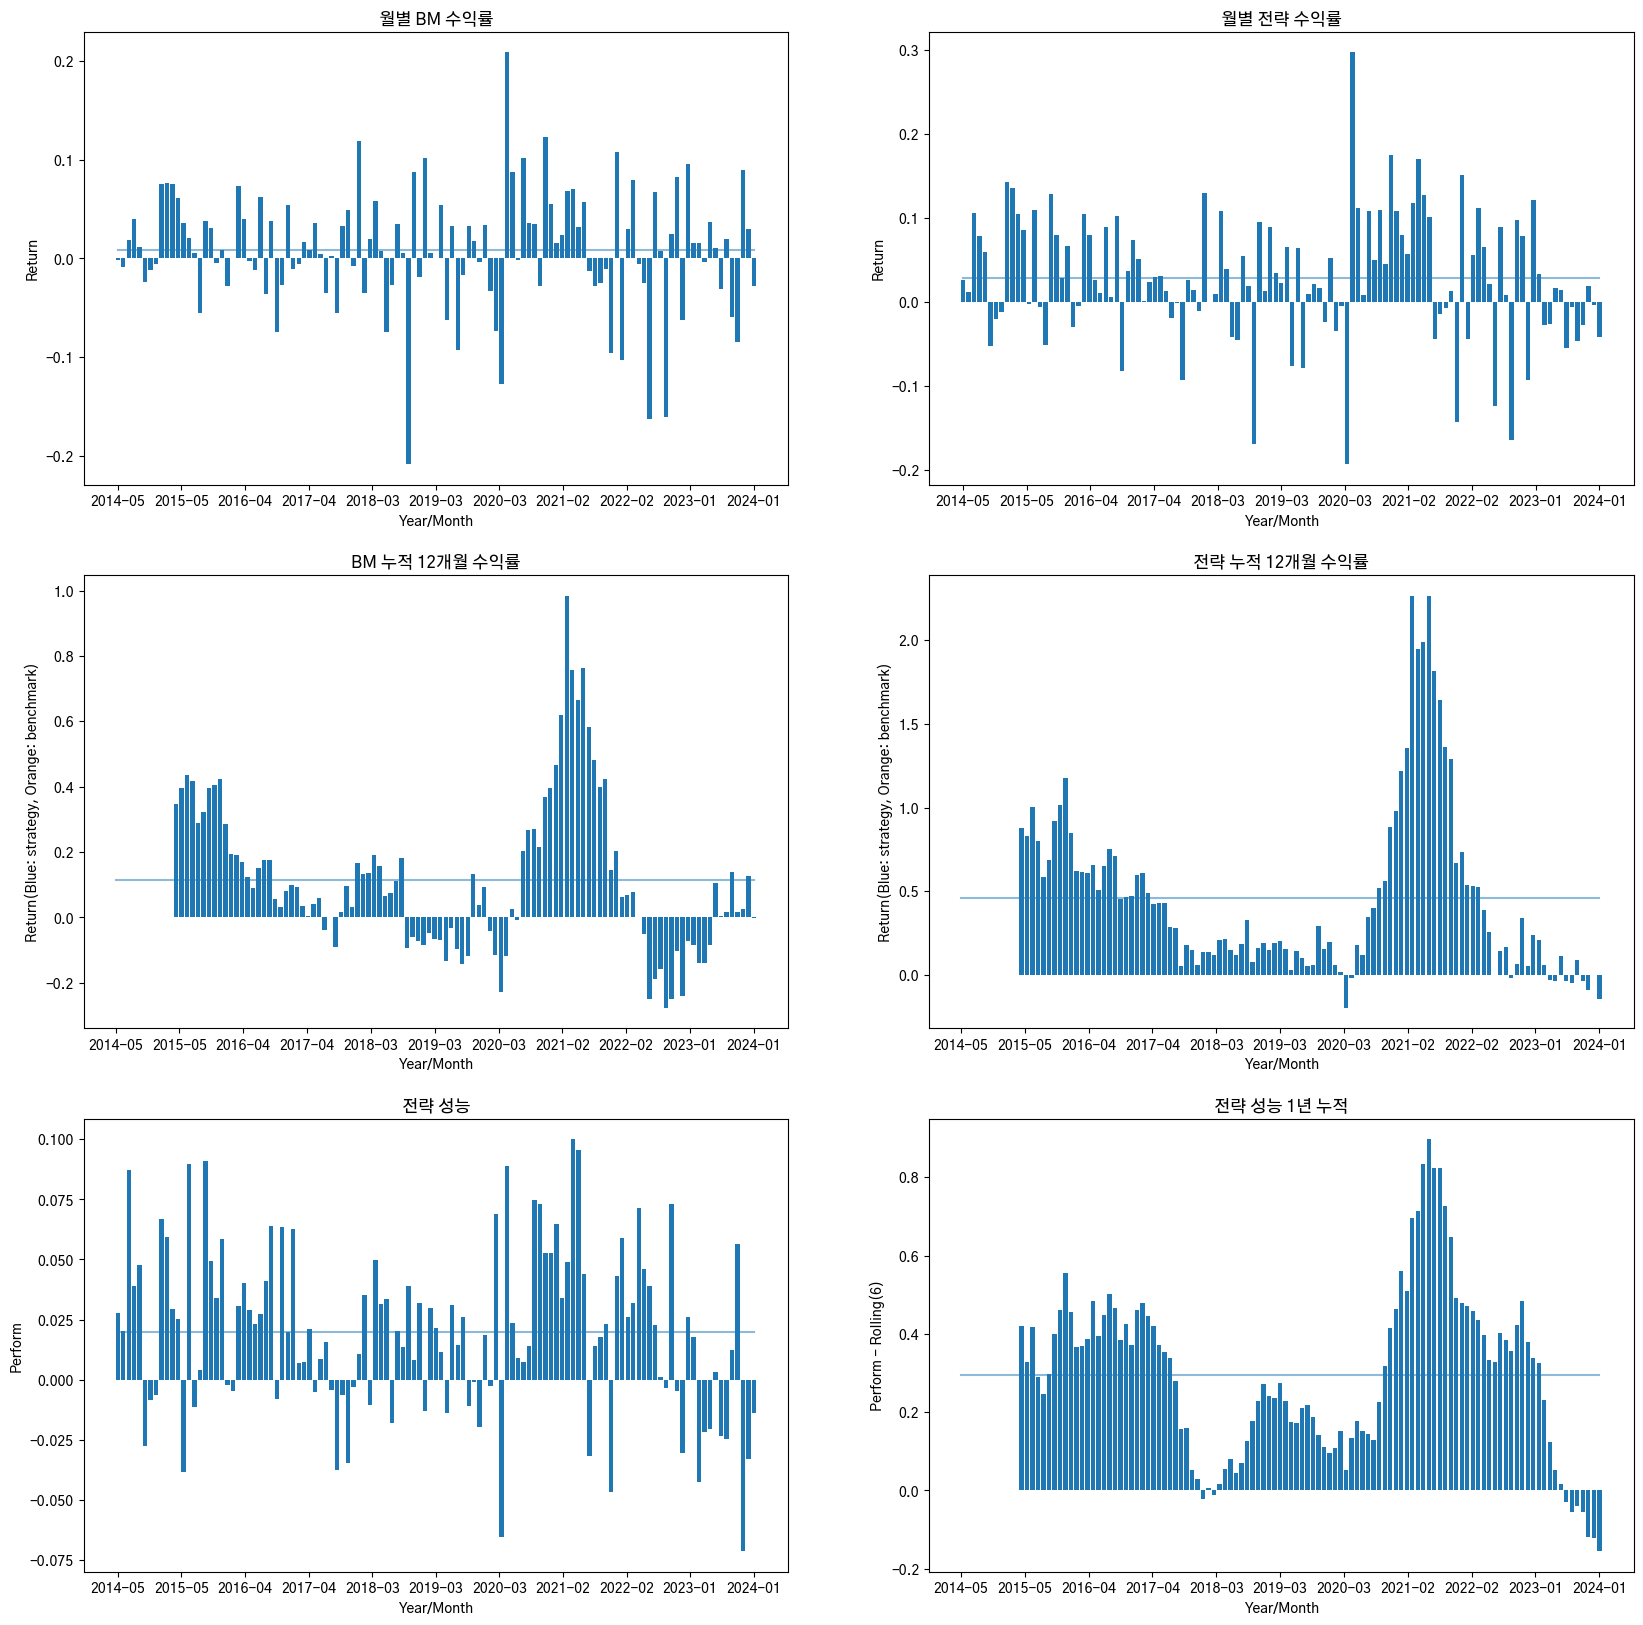

In [31]:
import numpy as np

months = [str(i) for _, i in revisions.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 BM 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["BM 수익률"])
ax1.plot(months, [revisions["BM 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"BM 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["BM 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "total": len(revisions),
    "out-perform": (revisions["성능"] > 0.01).sum(),
    "under-perform": (revisions["성능"] < -0.01).sum(),
    "승률": (revisions["성능"] > 0).sum() / len(revisions),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})

[2024-02-04 17:57:48.660] [INFO] [matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-02-04 17:57:48.662] [INFO] [matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-02-04 17:57:48.664] [INFO] [matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-02-04 17:57:48.666] [INFO] [matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


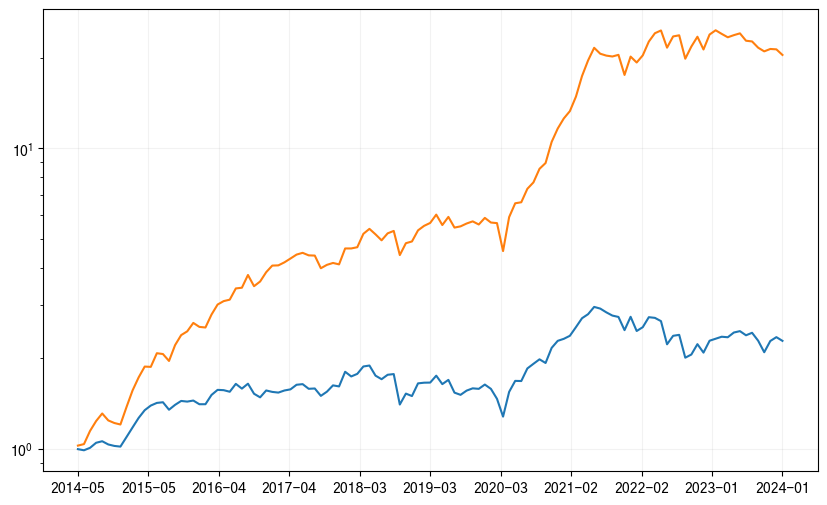

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 예시 생성
plt.figure(figsize=(10, 6))
plt.plot(months, revisions["BM 누적수익률"])
plt.plot(months, revisions["전략 누적수익률"])

plt.yscale('log')
plt.xticks(np.quantile(np.arange(0, len(revisions)), xticks))
plt.grid(True)